In [57]:
from src.data import *
#extract_frames('data/video/mario_gameplay.mp4', 5000, 8000, 10, 'data/mario', size=(256, 256))
split_data2('data/mario', test_split=0.2, num_frames=4)

In [58]:
from src.data import videoDataset
from torch.utils.data import DataLoader
dataset = videoDataset('data/mario', 'data/train.txt', (256, 256))
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

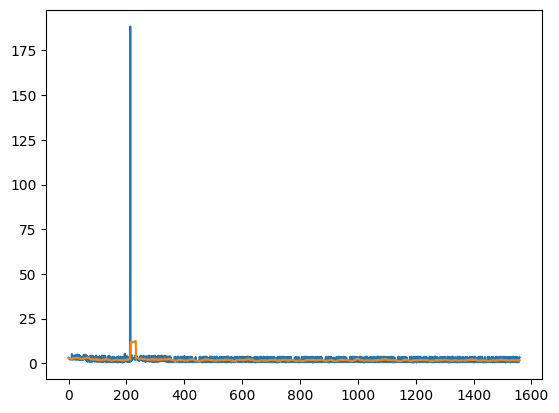

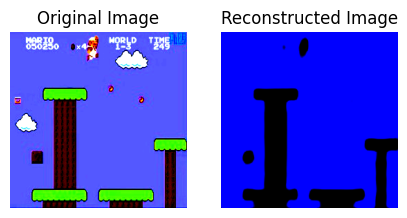

loss: 1.8303, epoch: 26, batch: 0


KeyboardInterrupt: 

In [59]:
from src.autoencoder import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
myvae = vae().to(device)
train(myvae, dataloader, dataset=dataset, lr=0.001, num_epochs=200)


In [ ]:
myvae

In [4]:
autoencoder = myvae
dataset2 = dataset

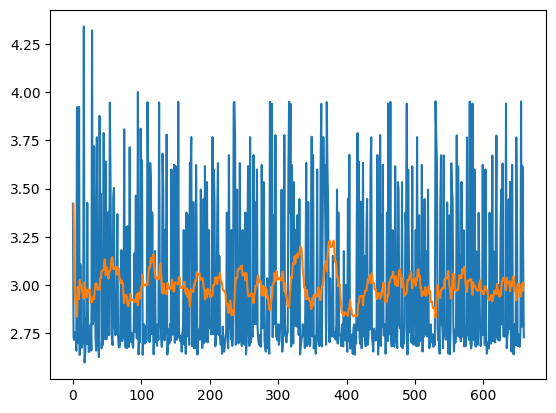

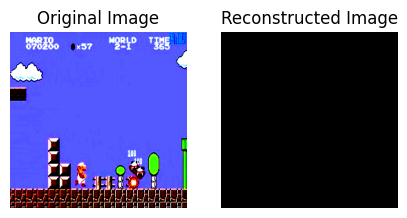

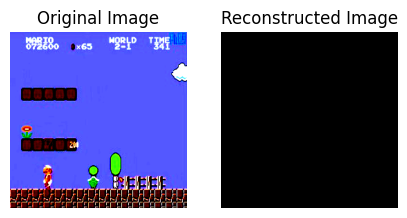

In [51]:
train(myvae, dataloader, lr=0.001, dataset=dataset, num_epochs=10)
sample_image(myvae, dataset, 0)

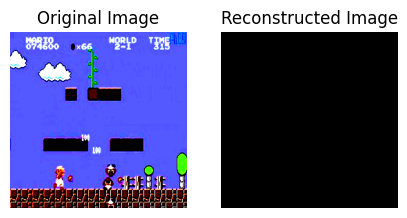

In [52]:
sample_image(myvae, dataset, 0)#, sample_image(autoencoder, dataset2, 0)

In [37]:
torch.save(myvae.state_dict(), 'weights/vaeKL_weights.pth')
torch.save(dataset, 'weights/datasetKL.pth')
